In [1]:
import math

import torch
from scipy.special import lambertw
from tqdm import tqdm

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import matplotlib.pyplot as plt
plt.style.use('scientific')

In [4]:
from rsnn.spike_sequences.sampling import backward_filtering_forward_sampling
from rsnn.spike_sequences.utils import segment_firing_sequences
from rsnn.learning.ikie import compute_box_prior, compute_posterior, compute_m_ary_prior
from rsnn.learning.utils import compute_observation_tensor, compute_jitter_transition_tensor
from rsnn.learning.utils import get_indices_refractory_period, get_indices_around_firing
from rsnn.utils.utils import indices_to_start_end

ImportError: cannot import name 'compute_jitter_transition_tensor' from 'rsnn.learning.utils' (/Users/haguettaz/Documents/RSNN/rsnn/learning/utils.py)

In [14]:
L, K, N, Nr, M = 200, 300, 200, 20, 3
spike_sequences = backward_filtering_forward_sampling(L, N, Nr)
spike_sequences[:, 2] = 0

In [21]:
org_input = -(1e9) * torch.ones(L, M + 1)  # init with too old spikes
for l in range(L):
    neuron_spikes = torch.argwhere(spike_sequences[:, l]).squeeze()
    num_spikes = neuron_spikes.numel()
    if num_spikes == 0:
        continue
    if num_spikes < M + 1:
        org_input[l, -num_spikes:] = neuron_spikes
    else:
        org_input[l] = neuron_spikes[-(M + 1) :]

In [22]:
import pandas as pd


tmp_input = org_input.clone() - N  # without noise
df = pd.DataFrame.from_dict({"l": torch.arange(L).repeat_interleave(M + 1), "s": tmp_input.flatten()})

In [23]:
df[df.l == 2]

,l,s
8,2,-1.000000e+09
9,2,-1.000000e+09
10,2,-1.000000e+09
11,2,-1.000000e+09


In [24]:
tmp_input

tensor([[-1.1000e+02, -8.1000e+01, -4.3000e+01, -1.3000e+01],
        [-1.1300e+02, -9.0000e+01, -5.4000e+01, -2.4000e+01],
        [-1.0000e+09, -1.0000e+09, -1.0000e+09, -1.0000e+09],
        [-1.4000e+02, -7.8000e+01, -4.3000e+01, -1.7000e+01],
        [-8.9000e+01, -6.7000e+01, -3.8000e+01, -9.0000e+00],
        [-9.0000e+01, -5.5000e+01, -2.8000e+01, -7.0000e+00],
        [-1.1700e+02, -7.8000e+01, -5.5000e+01, -3.4000e+01],
        [-1.1700e+02, -8.4000e+01, -5.1000e+01, -2.3000e+01],
        [-9.9000e+01, -6.5000e+01, -4.2000e+01, -1.0000e+00],
        [-1.1800e+02, -7.7000e+01, -5.3000e+01, -1.3000e+01],
        [-1.0000e+02, -5.8000e+01, -3.7000e+01, -1.4000e+01],
        [-8.7000e+01, -6.6000e+01, -3.7000e+01, -1.6000e+01],
        [-1.1400e+02, -8.5000e+01, -5.9000e+01, -2.6000e+01],
        [-1.6000e+02, -1.2800e+02, -4.8000e+01, -1.9000e+01],
        [-1.0700e+02, -7.2000e+01, -4.6000e+01, -1.8000e+01],
        [-1.1200e+02, -7.7000e+01, -4.9000e+01, -1.4000e+01],
        

In [15]:
delays = torch.FloatTensor(L,K).uniform_(0, M*Nr)
origins = torch.randint(0, L, (L,K))

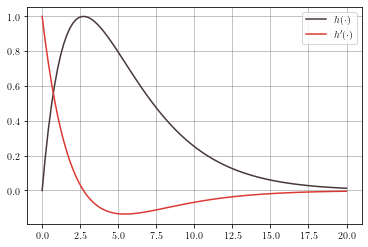

In [16]:
beta = -Nr / lambertw(-1e-3 / math.exp(1), -1).real
beta = math.exp(1)
impulse_resp = lambda t_: (t_>=0) * t_ / beta * torch.exp(1 - t_ / beta)
impulse_resp_deriv = lambda t_: 1/beta * (1 - t_/beta) * torch.exp(1 - t_/beta) * (t_ >= 0)

plt.plot(torch.linspace(0, Nr, 100), impulse_resp(torch.linspace(0, Nr, 100)))
plt.plot(torch.linspace(0, Nr, 100), impulse_resp_deriv(torch.linspace(0, Nr, 100)))
plt.legend([r"$h(\cdot)$", r"$h'(\cdot)$"])
plt.show()

In [9]:
eps = 1
wmax = 0.1
firing_thresh, resting_thresh = 1, 0
min_slope = (firing_thresh - resting_thresh)/eps

In [10]:
firing_segmentation = segment_firing_sequences(spike_sequences, Nr, eps)
at_firing = torch.argwhere(spike_sequences)
after_firing = torch.argwhere(firing_segmentation == 0)
before_firing = torch.argwhere(firing_segmentation == 1)
around_firing = torch.argwhere(firing_segmentation == 2)

In [11]:
# observation matrix
C = compute_observation_tensor(spike_sequences, delays, origins, Nr, (impulse_resp, impulse_resp_deriv))

In [12]:
def save_img(filename, itr, levels, slopes, weights, firing_times, orange_region, blue_region):
    fig, ax = plt.subplots(3, figsize=(20, 20))
    
    ax[0].set_title(f"score (level) at iteration {itr}")
    ax[1].set_title(f"score (slope) at iteration {itr}")
    ax[2].set_title(f"weights at iteration {itr}")

    # at firing
    for i in range(firing_times.size(0)):
        ax[0].axvline(firing_times[i], color='orange')
        ax[1].axvline(firing_times[i], color='orange')

    # around firing
    for i in range(orange_region[0].size(0)):
        ax[0].axvspan(orange_region[0][i] - 0.5, orange_region[1][i] + 0.5, facecolor='orange', alpha=0.3)
        ax[1].axvspan(orange_region[0][i] - 0.5, orange_region[1][i] + 0.5, facecolor='orange', alpha=0.3)

    # before firing
    for i in range(blue_region[0].size(0)):
        ax[0].axvspan(blue_region[0][i] - 0.5, blue_region[1][i] + 0.5, facecolor='blue', alpha=0.3)
        ax[1].axvspan(blue_region[0][i] - 0.5, blue_region[1][i] + 0.5, facecolor='blue', alpha=0.3)

    ax[0].axhline(resting_thresh, linestyle="dashed")
    ax[0].axhline(firing_thresh, linestyle="dashed")
    ax[1].axhline(min_slope, linestyle="dashed")
    ax[2].axhline(wmax, linestyle="dashed")
    ax[2].axhline(-wmax, linestyle="dashed")
        
    ax[0].plot(levels, color="red")
    ax[1].plot(slopes, color="red")
    ax[2].plot(weights, color="red")
    
    plt.savefig(filename)
    plt.close()

# 1. Box constraint

In [328]:
save = False

# init with random weights between wmin and wmax
mw = torch.FloatTensor(L,K).uniform_(-wmax,wmax)
my = (C @ mw.view(1, L, K, 1)).view(N, L, 2)

if save:
    orange_region = indices_to_start_end(torch.argwhere(firing_segmentation[:,42] == 2).flatten()) 
    blue_region = indices_to_start_end(torch.argwhere(firing_segmentation[:,42] == 1).flatten())  
    firing_times = torch.argwhere(spike_sequences[:,42])
    save_img("learning/box_learning_0.png", 0, my[:,42,0], my[:,42,1], mw[42].sort()[0], firing_times, orange_region, blue_region)

for itr in tqdm(range(1, 51)):
    # priors
    ## weights
    mw_f, Vw_f = compute_box_prior(mw, -wmax, wmax, 1000)
    
    ## inputs
    my_b = torch.zeros(N, L, 2)
    Vy_b = 1e9 * torch.ones(N, L, 2)
    my_b[before_firing[:,0],before_firing[:,1],0], Vy_b[before_firing[:,0],before_firing[:,1],0] = compute_box_prior(my[before_firing[:,0],before_firing[:,1],0], None, resting_thresh, 100)
    my_b[around_firing[:,0],around_firing[:,1],1], Vy_b[around_firing[:,0],around_firing[:,1],1] = compute_box_prior(my[around_firing[:,0],around_firing[:,1],1], min_slope, None, 1000)
    my_b[at_firing[:,0],at_firing[:,1],0], Vy_b[at_firing[:,0],at_firing[:,1],0] = compute_box_prior(my[at_firing[:,0],at_firing[:,1],0], firing_thresh, firing_thresh, 1)
        
    # posteriors
    mw, _, my = compute_posterior(mw_f, Vw_f, my_b, Vy_b, C)
    
    if save:
        save_img(f"learning/box_learning_{itr}.png", itr, my[:,42,0], my[:,42,1], mw[42].sort()[0], firing_times, orange_region, blue_region)

print(f"error weight is {(torch.abs(mw-wmax) + torch.abs(mw+wmax) - 2*wmax).sum().item()/L}")
print(f"error at firing time is {(my_b[at_firing[:,0], at_firing[:,1], 0] - firing_thresh).abs().sum().item()/L}")
print(f"error around firing time is {torch.maximum(min_slope - my[around_firing[:,0],around_firing[:,1],1], torch.tensor(0)).sum().item()/L}")
print(f"error before firing time is {torch.maximum(my[before_firing[:,0],before_firing[:,1],0] - resting_thresh, torch.tensor(0)).sum().item()/L}")

100%|███████████████████████████████████████████| 50/50 [06:59<00:00,  8.39s/it]

error weight is 0.1894119644165039
error at firing time is 0.0
error around firing time is 0.04388230323791504
error before firing time is 0.0010974971950054168


In [14]:
N, L, K, Nr, M

(200, 200, 300, 20, 3)

In [15]:
min_slope, wmax, eps

(1.0, 0.1, 1)

In [17]:
# torch.save(mw, "weights_box.pt")
# torch.save(delays, "delays.pt")
# torch.save(origins, "origins.pt")
# torch.save(spike_sequences, "spike_sequences.pt")

In [18]:
mw = torch.load("weights_box.pt")
delays = torch.load("delays.pt")
origins = torch.load("origins.pt")
spike_sequences = torch.load("spike_sequences.pt")

In [19]:
A = compute_jitter_transition_tensor(spike_sequences, mw, delays, origins, Nr, impulse_resp_deriv)

In [22]:
A.size()

torch.Size([200, 800, 800])

In [23]:
torch.linalg.eigvals(A).abs().min()

tensor(0.)

In [20]:
eigvals, _  = torch.linalg.eigvals(A).abs().min(dim=1)
eigvals.sort()[0]

tensor([0.0000e+00, 6.4751e-12, 7.0725e-12, 2.3415e-11, 2.9520e-11, 3.2140e-11,
        4.3820e-11, 6.1657e-11, 7.9993e-11, 8.8780e-11, 1.2709e-10, 1.5276e-10,
        2.9493e-10, 4.0992e-10, 4.3540e-10, 5.0658e-10, 7.5470e-10, 8.9182e-10,
        1.0511e-09, 1.9331e-09, 2.0371e-09, 2.0670e-09, 2.1189e-09, 2.4701e-09,
        2.5008e-09, 2.7681e-09, 3.1287e-09, 3.2102e-09, 4.0791e-09, 4.6076e-09,
        4.7052e-09, 5.3169e-09, 5.3978e-09, 5.7759e-09, 5.9731e-09, 6.4358e-09,
        6.6663e-09, 7.5601e-09, 7.9009e-09, 8.7846e-09, 9.8347e-09, 1.0090e-08,
        1.2271e-08, 1.3043e-08, 1.3185e-08, 1.4133e-08, 1.4187e-08, 1.4903e-08,
        1.5341e-08, 1.5453e-08, 1.7468e-08, 1.8636e-08, 2.3796e-08, 2.4565e-08,
        2.4725e-08, 2.5032e-08, 2.5632e-08, 2.7222e-08, 2.8633e-08, 3.0434e-08,
        3.3407e-08, 3.3838e-08, 3.4508e-08, 3.6856e-08, 3.8180e-08, 4.0761e-08,
        4.1598e-08, 4.4425e-08, 4.9934e-08, 5.0154e-08, 5.1941e-08, 5.5048e-08,
        5.7089e-08, 5.8491e-08, 5.9389e-

In [24]:
Phi = torch.eye((M+1)*L)

for n in range(N):
    Phi = A[n] @ Phi
    
torch.linalg.eigvals(Phi).abs().max()

tensor(1.0000)

In [25]:
Phi = torch.eye((M+1)*L)

for n in range(N):
    Phi = A[(10 + n)%N] @ Phi
    
torch.linalg.eigvals(Phi).abs().max()

tensor(1.0000)

In [26]:
for n0 in range(N):
    Phi = torch.eye((M+1)*L)
    for n in range(N):
        Phi = A[(n0 + n)%N] @ Phi
    print(n0, torch.linalg.eigvals(Phi).abs().max())

0 tensor(1.0000)
1 tensor(1.0000)
2 tensor(1.0000)
3 tensor(1.0000)
4 tensor(1.0000)
5 tensor(1.0000)
6 tensor(1.0000)
7 tensor(1.0000)
8 tensor(1.0000)
9 tensor(1.0000)
10 tensor(1.0000)
11 tensor(1.0000)
12 tensor(1.)
13 tensor(1.0000)
14 tensor(1.0000)
15 tensor(1.0000)
16 tensor(1.0000)
17 tensor(1.0000)
18 tensor(1.0000)
19 tensor(1.0000)
20 tensor(1.0000)
21 tensor(1.0000)
22 tensor(1.0000)
23 tensor(1.0000)
24 tensor(1.0000)
25 tensor(1.0000)
26 tensor(1.0000)
27 tensor(1.)
28 tensor(1.0000)
29 tensor(1.0000)
30 tensor(1.0000)
31 tensor(1.0000)
32 tensor(1.0000)
33 tensor(1.0000)
34 tensor(1.0000)
35 tensor(1.0000)
36 tensor(1.0000)
37 tensor(1.0000)
38 tensor(1.0000)
39 tensor(1.0000)
40 tensor(1.0000)
41 tensor(1.0000)
42 tensor(1.0000)
43 tensor(1.0000)
44 tensor(1.0000)
45 tensor(1.0000)
46 tensor(1.0000)
47 tensor(1.0000)
48 tensor(1.0000)
49 tensor(1.0000)
50 tensor(1.0000)
51 tensor(1.0000)
52 tensor(1.0000)
53 tensor(1.0000)
54 tensor(1.0000)
55 tensor(1.0000)
56 tensor(

In [29]:
eigvals = torch.linalg.eigvals(Phi).abs()

In [35]:
Phi.T@Phi, Phi@Phi.T

(tensor([[ 2.5813e-03,  5.3277e-05,  9.5901e-09,  ...,  3.2279e-03,
          -4.3388e-06, -9.8587e-10],
         [ 5.3277e-05,  2.0275e-06,  3.7194e-10,  ...,  1.0360e-04,
          -1.4617e-07, -3.3362e-11],
         [ 9.5901e-09,  3.7194e-10,  6.8608e-14,  ...,  1.8768e-08,
          -2.6502e-11, -6.0477e-15],
         ...,
         [ 3.2279e-03,  1.0360e-04,  1.8768e-08,  ...,  7.0613e-03,
          -8.6383e-06, -1.9659e-09],
         [-4.3388e-06, -1.4617e-07, -2.6502e-11,  ..., -8.6383e-06,
           1.3944e-08,  3.1863e-12],
         [-9.8587e-10, -3.3362e-11, -6.0477e-15,  ..., -1.9659e-09,
           3.1863e-12,  7.2851e-16]]),
 tensor([[0.0037, 0.0037, 0.0038,  ..., 0.0037, 0.0037, 0.0037],
         [0.0037, 0.0039, 0.0038,  ..., 0.0037, 0.0037, 0.0038],
         [0.0038, 0.0038, 0.0204,  ..., 0.0037, 0.0036, 0.0036],
         ...,
         [0.0037, 0.0037, 0.0037,  ..., 0.0037, 0.0037, 0.0036],
         [0.0037, 0.0037, 0.0036,  ..., 0.0037, 0.0040, 0.0037],
         [0.003

In [32]:
eigvals.sort(descending=True)[0]

tensor([1.0000e+00, 4.4649e-03, 4.4649e-03, 4.4493e-03, 4.4493e-03, 4.3859e-03,
        4.3859e-03, 4.2346e-03, 4.2346e-03, 4.0809e-03, 4.0809e-03, 3.9513e-03,
        3.9513e-03, 3.8223e-03, 3.8223e-03, 3.7932e-03, 3.7932e-03, 3.6084e-03,
        3.6084e-03, 3.5817e-03, 3.5817e-03, 3.4467e-03, 3.4467e-03, 3.3708e-03,
        3.3708e-03, 3.2936e-03, 3.2936e-03, 3.2692e-03, 3.0999e-03, 3.0999e-03,
        3.0942e-03, 3.0942e-03, 3.0881e-03, 3.0881e-03, 3.0880e-03, 3.0828e-03,
        3.0828e-03, 3.0535e-03, 3.0535e-03, 2.9406e-03, 2.9406e-03, 2.7559e-03,
        2.7559e-03, 2.7402e-03, 2.7402e-03, 2.6457e-03, 2.6457e-03, 2.5926e-03,
        2.5926e-03, 2.5696e-03, 2.5696e-03, 2.5642e-03, 2.5642e-03, 2.5396e-03,
        2.5396e-03, 2.5317e-03, 2.5317e-03, 2.4482e-03, 2.4482e-03, 2.4123e-03,
        2.4123e-03, 2.4042e-03, 2.1760e-03, 2.1760e-03, 2.1750e-03, 2.1750e-03,
        2.1172e-03, 2.1172e-03, 2.0428e-03, 2.0428e-03, 2.0333e-03, 2.0333e-03,
        1.9890e-03, 1.9890e-03, 1.9637e-

# 2. M-level constraint

In [16]:
# random init of the prior messages
M = 7
mws = torch.FloatTensor(L,M-1,K).normal_((wmin + wmax)/(M-1), (wmax - wmin)/(M-1) * 1e-2)
mw = mws.sum(dim=1)
my = (C @ mw.view(L, 1, K, 1)).view(L, N, 2)

# add frames to gif
l = 42
frames = []
frame = add_frame(0, mw[l], my[l], theta, eta, dymin, wmin, wmax, mask_at_firing[l], mask_around_firing[l], mask_refractory_period[l])
frames.append(frame)

for itr in tqdm(range(1, 101)):
    # priors
    ## weights
    mws_f, Vws_f = compute_m_ary_prior(mws, None, wmin, wmax, M, "am")
    mw_f, Vw_f = mws_f.sum(dim=1), Vws_f.sum(dim=1)

    ## action potentials
    my_b = torch.zeros(L,N, 2)
    Vy_b = 1e9 * torch.ones(L,N, 2)  
    my_b[...,0][mask_before_firing], Vy_b[...,0][mask_before_firing] = compute_box_prior(my[...,0][mask_before_firing], None, eta, 100)
    my_b[...,1][mask_around_firing], Vy_b[...,1][mask_around_firing] = compute_box_prior(my[...,1][mask_around_firing], dymin, None, 200)
    my_b[...,0][mask_at_firing], Vy_b[...,0][mask_at_firing] = compute_box_prior(my[...,0][mask_at_firing], theta, theta, 200)

    # posteriors
    mw, Vw, my = compute_posterior(mw_f, Vw_f, my_b, Vy_b, C)
    xiw = Vw_f.pow(-1) * (mw_f - mw) # (IV.9) in Loeliger2016
    mws = mws_f - Vws_f * xiw.unsqueeze(1) # (IV.9) in Loeliger2016
    
    frame = add_frame(itr, mw[l], my[l], theta, eta, dymin, wmin, wmax, mask_at_firing[l], mask_around_firing[l], mask_refractory_period[l])
    frames.append(frame)
    
print(f"error at firing time is {(my[...,0][mask_at_firing] - theta).pow(2).sum().item()/L}")
print(f"error around firing time is {torch.maximum(dymin - my[...,1][mask_around_firing], torch.tensor(0)).sum().item()/L}")
print(f"error before firing time is {torch.maximum(my[...,0][mask_before_firing] - eta, torch.tensor(0)).sum().item()/L}")

RuntimeError: The size of tensor a (100) must match the size of tensor b (200) at non-singleton dimension 0

In [ ]:
if frames:
    gif.save(frames, "7_ary_am.gif", duration=150)

In [ ]:
# random init of the prior messages
M = 7
mws = torch.FloatTensor(L,M-1,K).normal_((wmin + wmax)/(M-1), (wmax - wmin)/(M-1) * 1e-2)
Vws = torch.FloatTensor(L,M-1,K).normal_((wmax - wmin)/(M-1) * 1e-1, (wmax - wmin)/(M-1) * 1e-3)
mw = mws.sum(dim=1)
my = (C @ mw.view(L, 1, K, 1)).view(L, N, 2)

# add frames to gif
l = 42
frames = []
frame = add_frame(0, mw[l], my[l], theta, eta, dymin, wmin, wmax, mask_at_firing[l], mask_around_firing[l], mask_refractory_period[l])
frames.append(frame)

for itr in tqdm(range(1, 301)):
    # priors
    ## weights
    mws_f, Vws_f = compute_m_ary_prior(mws, Vws, wmin, wmax, M, "em")
    mw_f, Vw_f = mws_f.sum(dim=1), Vws_f.sum(dim=1)
        
    ## action potentials
    my_b = torch.zeros(L,N, 2)
    Vy_b = 1e9 * torch.ones(L,N, 2)  
    my_b[...,0][mask_before_firing], Vy_b[...,0][mask_before_firing] = compute_box_prior(my[...,0][mask_before_firing], None, eta, 100)
    my_b[...,1][mask_around_firing], Vy_b[...,1][mask_around_firing] = compute_box_prior(my[...,1][mask_around_firing], dymin, None, 200)
    my_b[...,0][mask_at_firing], Vy_b[...,0][mask_at_firing] = compute_box_prior(my[...,0][mask_at_firing], theta, theta, 200)
        
    # posteriors
    mw, Vw, my = compute_posterior(mw_f, Vw_f, my_b, Vy_b, C)

    xiw = Vw_f.pow(-1) * (mw_f - mw) # (IV.9) in Loeliger2016
    Ww = Vw_f.pow(-2) * (Vw_f - Vw) # (IV.13) in Loeliger2016
    
    mws = mws_f - Vws_f * xiw.unsqueeze(1) # (IV.9) in Loeliger2016
    Vws = Vws_f - Vws_f.pow(2) * Ww.unsqueeze(1) # (IV.13) in Loeliger2016
    
    # add frames to gif
    frame = add_frame(itr, mw[l], my[l], theta, eta, dymin, wmin, wmax, mask_at_firing[l], mask_around_firing[l], mask_refractory_period[l])
    frames.append(frame)
    
print(f"error at firing time is {(my[...,0][mask_at_firing] - theta).abs().sum().item()/L}")
print(f"error around firing time is {torch.maximum(dymin - my[...,1][mask_around_firing], torch.tensor(0)).sum().item()/L}")
print(f"error before firing time is {torch.maximum(my[...,0][mask_before_firing] - eta, torch.tensor(0)).sum().item()/L}")

In [ ]:
if frames:
    gif.save(frames, "7_ary_em.gif", duration=150)